# Optimize, Monitor and Track Classification task

Several years ago, I had health issues. I visited many doctors and did more than 30 blood tests within 3 years. It was impossible for a doctor to review all medical conclusions and to keep track of all blood tests. Therefore, I started to put everything in an Excel sheet - date of test / examination, medical indicator, and value. Thus, any doctor would have been able to track past fluctuations or significant changes of my health status. I printed out this health monitoring sheet (which took 8 A4 pages) and visited the next doctor. The first thing he asked me was "what is your occupation?". He admitted that I was the first patient he ever had who organised her medical examinations and tests in a way which allows tracking status back in time (this happened a few years before I turned to Data Science). Thus, this doctor was able to get the whole picture, and recommended further tests which helped me to solve my health issue. At that time, without having no clue what is going on around the Data Science / AI world, I realized that there is a huge potential in medical data. 

This Notebook is my first encounter with real medical data. I use the [Patient Survival Prediction dataset](https://www.kaggle.com/mitishaagarwal/patient) to explore its features, to search a model that best predicts whether a person is going to survive a hospital stay, or not, to monitor model performance, and to track and log model artifacts in [Neptune](https://docs.neptune.ai/).

The work is orgnanised into several chapters and subsections. First, I load the data. Exploratory Data Analysis and Data Cleansing follows thereafter. Data Preprocessing is done in Chapter III. Hyperparameters optimization and data modelling is presented in Chapter IV. Its subsections explore model performance.

### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

import scikitplot as skplt

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

import shap
import neptune.new as neptune

### Connect Notebook to a `Neptune` project

To track model performance and to log model artefacts (e.g., model, success metrics, etc.), the Notebook is connected to a `Neptune` project. The latter should be created prior running the code line below. `Neptune` assigns an api_token to each subscriber, which is used to log in it. 

*Note: project and api_token are not visible due to security considerations.*

In [3]:
run = neptune.init(
    project = "*************",
    api_token = "********************",
)

https://app.neptune.ai/aneta.kovacheva/Patient-survival/e/PAT-7


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## I. Load Data

Patient Survival Dataset was downloaded from Kaggle and loaded from local computer. The data are stored in `patient_dataset`. It has 91713 samples and 85 features (columns).

In [4]:
patient_dataset = pd.read_csv("dataset.csv")

In [5]:
patient_dataset.shape

(91713, 85)

In [6]:
patient_dataset.head(3)

encounter_id  patient_id  hospital_id   age    bmi  elective_surgery  \
0         66154       25312          118  68.0  22.73                 0   
1        114252       59342           81  77.0  27.42                 0   
2        119783       50777          118  25.0  31.95                 0   

   ethnicity gender  height      icu_admit_source  ...  diabetes_mellitus  \
0  Caucasian      M   180.3                 Floor  ...                1.0   
1  Caucasian      F   160.0                 Floor  ...                1.0   
2  Caucasian      F   172.7  Accident & Emergency  ...                0.0   

  hepatic_failure immunosuppression  leukemia  lymphoma  \
0             0.0               0.0       0.0       0.0   
1             0.0               0.0       0.0       0.0   
2             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0             Metabolic            Metabolic   

   Unnamed: 83  hospital_death  
0          NaN               0  
1          NaN               0  
2          NaN               0  

[3 rows x 85 columns]

Dataset's authors explain that predictors of in-hospital mortality for admitted patients remain poorly characterized. Thus, they aim to develop and validate a predictive model for all-cause in-hospital mortality among admitted patients. In this Dataset, various factors are given, which are involved when a patient is hospitalized. On the basis of these factors, the task is to predict whether the patient will survive or not.

The Dataset does not come with column description. Thus, the information they hold and its interpretation is based entirely on publications found on the Internet.2

## II. Exploratory Data Analysis. Data Cleansing

There are many missing values in the Dataset. Most columns hold numeric values. There are a few categorical features.

In [7]:
patient_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

Due to the large number of columns, the statistical properties of all numeric features are not printed out. However, it could be seen that there are binary columns, i.e., such that hold either 0 or 1 (False or True, respectively). `Unnamed: 83` does not have any values and is removed later.

In [8]:
patient_dataset.describe().T

count          mean           std        min  \
encounter_id                 91713.0  65606.079280  37795.088538   1.000000   
patient_id                   91713.0  65537.131464  37811.252183   1.000000   
hospital_id                  91713.0    105.669262     62.854406   2.000000   
age                          87485.0     62.309516     16.775119  16.000000   
bmi                          88284.0     29.185818      8.275142  14.844926   
...                              ...           ...           ...        ...   
leukemia                     90998.0      0.007066      0.083763   0.000000   
lymphoma                     90998.0      0.004132      0.064148   0.000000   
solid_tumor_with_metastasis  90998.0      0.020638      0.142169   0.000000   
Unnamed: 83                      0.0           NaN           NaN        NaN   
hospital_death               91713.0      0.086302      0.280811   0.000000   

                                      25%           50%           75%  \
encounter_id                 32852.000000  65665.000000  98342.000000   
patient_id                   32830.000000  65413.000000  98298.000000   
hospital_id                     47.000000    109.000000    161.000000   
age                             52.000000     65.000000     75.000000   
bmi                             23.641975     27.654655     32.930206   
...                                   ...           ...           ...   
leukemia                         0.000000      0.000000      0.000000   
lymphoma                         0.000000      0.000000      0.000000   
solid_tumor_with_metastasis      0.000000      0.000000      0.000000   
Unnamed: 83                           NaN           NaN           NaN   
hospital_death                   0.000000      0.000000      0.000000   

                                      max  
encounter_id                 131051.00000  
patient_id                   131051.00000  
hospital_id                     204.00000  
age                              89.00000  
bmi                              67.81499  
...                                   ...  
leukemia                          1.00000  
lymphoma                          1.00000  
solid_tumor_with_metastasis       1.00000  
Unnamed: 83                           NaN  
hospital_death                    1.00000  

[78 rows x 8 columns]

The code lines below display Null values (`NaNs`) in each feature.

In [9]:
cols_with_nans = patient_dataset.isna().sum()

In [10]:
for col, nans in cols_with_nans.items():
    print(f"{col}: {nans}")

encounter_id: 0
patient_id: 0
hospital_id: 0
age: 4228
bmi: 3429
elective_surgery: 0
ethnicity: 1395
gender: 25
height: 1334
icu_admit_source: 112
icu_id: 0
icu_stay_type: 0
icu_type: 0
pre_icu_los_days: 0
weight: 2720
apache_2_diagnosis: 1662
apache_3j_diagnosis: 1101
apache_post_operative: 0
arf_apache: 715
gcs_eyes_apache: 1901
gcs_motor_apache: 1901
gcs_unable_apache: 1037
gcs_verbal_apache: 1901
heart_rate_apache: 878
intubated_apache: 715
map_apache: 994
resprate_apache: 1234
temp_apache: 4108
ventilated_apache: 715
d1_diasbp_max: 165
d1_diasbp_min: 165
d1_diasbp_noninvasive_max: 1040
d1_diasbp_noninvasive_min: 1040
d1_heartrate_max: 145
d1_heartrate_min: 145
d1_mbp_max: 220
d1_mbp_min: 220
d1_mbp_noninvasive_max: 1479
d1_mbp_noninvasive_min: 1479
d1_resprate_max: 385
d1_resprate_min: 385
d1_spo2_max: 333
d1_spo2_min: 333
d1_sysbp_max: 159
d1_sysbp_min: 159
d1_sysbp_noninvasive_max: 1027
d1_sysbp_noninvasive_min: 1027
d1_temp_max: 2324
d1_temp_min: 2324
h1_diasbp_max: 3619
h1_dia

### II.1. Drop unnecessary columns and samples with `NaN` values 

Some columns hold many unique values which makes their entropy too high. For example, both `encounter_id` and `patient_id` are unique identifiers that wouldn't be good predictors.

In [11]:
len(patient_dataset["encounter_id"].unique())

91713

In [12]:
len(patient_dataset["patient_id"].unique())

91713

`hospital_id` most likely is an ID of hospitals where patients stayed for treatment. The code line below shows that 147 hospitals provided anonymised data about their patients. There is less entropy (disorder) in this column and for this reason it is kept in the Dataset.

In [13]:
len(patient_dataset["hospital_id"].unique())

147

For the time being, only `encounter_id`, `patient_id`, and `Unnamed: 83` are removed. Samples with `NaN` values in the other columns are dropped thereafter.

In [14]:
patient_dataset = patient_dataset.drop(["encounter_id", "patient_id", "Unnamed: 83"], axis = 1)

In [15]:
patient_dataset = patient_dataset.dropna()

A brief check shows that more than 30000 entries were removed. The Dataset has 56935 samples and 82 features now. 

In [16]:
patient_dataset.shape

(56935, 82)

In [17]:
patient_dataset.head(3)

hospital_id   age    bmi  elective_surgery  ethnicity gender  height  \
0          118  68.0  22.73                 0  Caucasian      M   180.3   
1           81  77.0  27.42                 0  Caucasian      F   160.0   
5           83  67.0  27.56                 0  Caucasian      M   190.5   

       icu_admit_source  icu_id icu_stay_type  ... cirrhosis  \
0                 Floor      92         admit  ...       0.0   
1                 Floor      90         admit  ...       0.0   
5  Accident & Emergency      95         admit  ...       0.0   

   diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  lymphoma  \
0                1.0              0.0                0.0       0.0       0.0   
1                1.0              0.0                0.0       0.0       0.0   
5                1.0              0.0                0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
5                          0.0          Neurological           Neurologic   

   hospital_death  
0               0  
1               0  
5               0  

[3 rows x 82 columns]

Values in index column were reset to preserve table integrity.

In [18]:
patient_dataset = patient_dataset.reset_index()

In [19]:
patient_dataset.drop("index", axis = 1, inplace = True)

In [20]:
patient_dataset.head(3)

hospital_id   age    bmi  elective_surgery  ethnicity gender  height  \
0          118  68.0  22.73                 0  Caucasian      M   180.3   
1           81  77.0  27.42                 0  Caucasian      F   160.0   
2           83  67.0  27.56                 0  Caucasian      M   190.5   

       icu_admit_source  icu_id icu_stay_type  ... cirrhosis  \
0                 Floor      92         admit  ...       0.0   
1                 Floor      90         admit  ...       0.0   
2  Accident & Emergency      95         admit  ...       0.0   

   diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  lymphoma  \
0                1.0              0.0                0.0       0.0       0.0   
1                1.0              0.0                0.0       0.0       0.0   
2                1.0              0.0                0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0          Neurological           Neurologic   

   hospital_death  
0               0  
1               0  
2               0  

[3 rows x 82 columns]

### II.2. Explore distributions and counts

This subsection shows features distributions and counts. The functions below help for this task. To spare space and time, distributions in most numerical features are displayed on subplots. Each plot is followed or preceded by a brief comment.

In [21]:
def plot_distribution(col, bins):
    """
    Plots distribution of continuous values in a feature
    Args:
        col: string, feature name
        bins: int, number of bins
    """
    sns.histplot(x = col, data = patient_dataset, bins = bins)
    
    plt.xlabel(f"{col}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of '{col}' values")
    plt.show()

In [22]:
def plot_counts(col):
    """
    Plots counts in a feature with descrete (categorical) values
    Args:
        col: string, feature name
    """
    sns.countplot(x = col, data = patient_dataset)
    plt.ylabel("Counts")
    plt.title(f"Counts in '{col}' per category")
    plt.show()

#### `Age`

Values in `Age` are not normally distributed but are skewed on the left. Mean age is above 60. The youngest patient was 16 years, and the oldest one was 89.

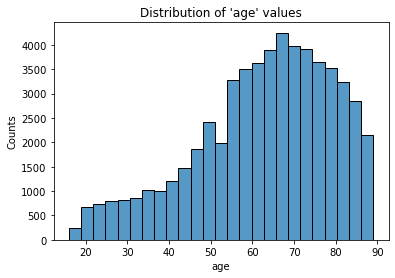

In [23]:
plot_distribution("age", 25)

In [24]:
patient_dataset["age"].min(), patient_dataset["age"].mean(), patient_dataset["age"].max() 

(16.0, 62.58614209185914, 89.0)

### `bmi`

`bmi` - short of Body Mass Index, is a value derived from the mass and height of a person. The BMI is defined as the body mass divided by the square of the body height, and is expressed in units of kg/m², resulting from mass in kilograms and height in metres ([ref](https://en.wikipedia.org/wiki/Body_mass_index)). High (above 25) *bmi* might suggest overweight or obesity, and low (below 16) - underweight person.

Most patients were overweight or obese.

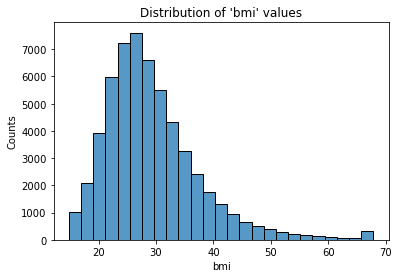

In [25]:
plot_distribution("bmi", 25)

In [26]:
patient_dataset["bmi"].describe()

count    56935.000000
mean        29.288534
std          8.320370
min         14.844926
25%         23.704715
50%         27.768126
75%         33.062057
max         67.814990
Name: bmi, dtype: float64

### `Elective Surgery`

Elective surgery is a surgery that is scheduled in advance because it does not involve a medical emergency ([ref](https://en.wikipedia.org/wiki/Elective_surgery)). Most patients' medical condition was not recognized to be subject to  elective surgery.

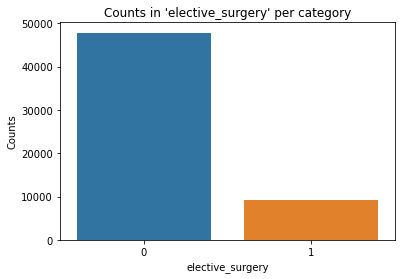

In [27]:
plot_counts("elective_surgery")

### `Ethnicity`

Most patients were Caucausian. Much smaller share were African Americans or Hispanic.

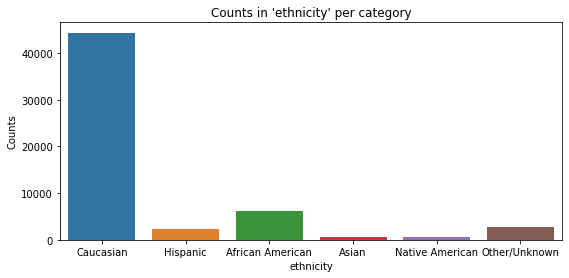

In [28]:
plt.figure(figsize = (9, 4))
plot_counts("ethnicity")

### `Gender`

Male patients slightly outnumbered female ones.

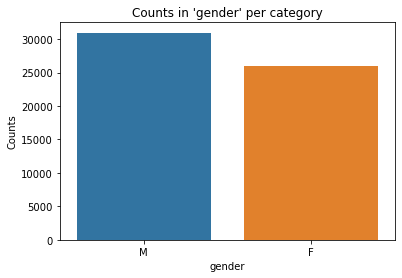

In [29]:
plot_counts("gender")

### `Height`

Values in `height` are normally distributed. Most patients were between 150 nd 185 cm tall.

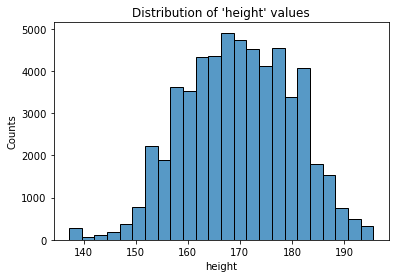

In [30]:
plot_distribution("height", 24)

### `ICU Admit Source`

ICU stands for "Intensive Care Unit". This feature shows where patients come to the ICU from. Most of them came from "Emergency" Unit due to Accident. Around 10000 were already admitted to the hospital and came from another floor. The same number of people directly came from the Operating room. Only a tiny number of patients were transfered from another hospital or ICU.

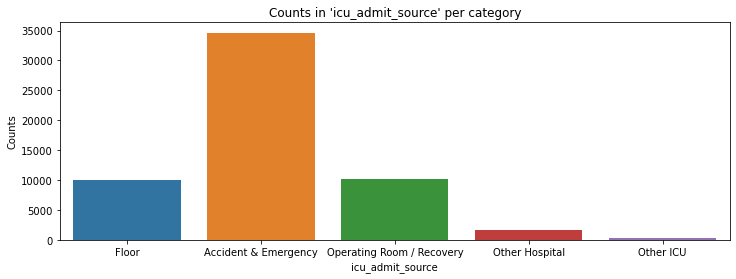

In [31]:
plt.figure(figsize = (12, 4))
plot_counts("icu_admit_source")

### `ICU ID`

`icu_id` most likely is a unique identifier of an intensive care unit. If so, the Dataset holds information from 214 ICUs.

In [32]:
len(patient_dataset["icu_id"].unique()) 

214

### `ICU Stay Type`

Stay in an ICU could be due to regular *admit* (as was the case of most patients), *readmit* (due to health complications after discharge), or *transfer* (from another hospital or ICU).

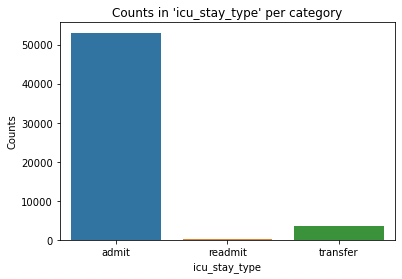

In [33]:
plot_counts("icu_stay_type")

### `ICU Type`

Intensive Care Units in the Dataset are:

- *CTICU*: Cardiac
- *Med-Surg ICU*: Medical Surgery
- *Neuro ICU*: Neurologic
- *MICU*: Medical (for close observation)
- *CCU-CTICU*: Medically treated heart patients - Cardiac Surgery
- *SICU*: Surgical
- *Cardiac*: for individuals who have had a cardiac emergency
- *CSICU*: Cardiac Surgical Intensive Care Units

Explanation of these abbreviations was taken from [here](https://www.indeed.com/career-advice/career-development/types-of-icu) and [here](https://www.ottawaheart.ca/the-beat/2014/06/23/cardiac-surgery-icu-making-complex-recovery-possible).

These sources show that ICU types overlap. Most patients were treated in ICUs after Medical Surgery. 

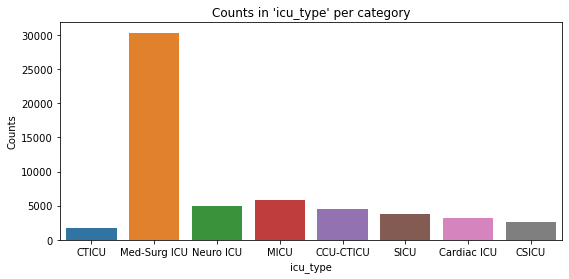

In [34]:
plt.figure(figsize = (9, 4))
plot_counts("icu_type")

### `Pre ICU LOS Days`

This feature holds information about the number of days a patient stayed in the hospital before being admitted to an ICU. There are negative values which most likely is an error: "number of days" could be only a positive figure.

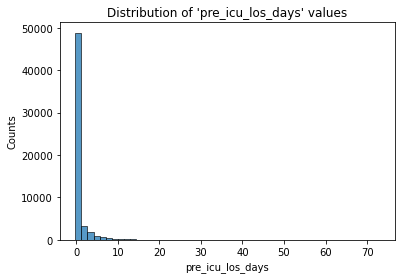

In [35]:
plot_distribution("pre_icu_los_days", 50) 

In [36]:
patient_dataset["pre_icu_los_days"].min(), patient_dataset["pre_icu_los_days"].max()

(-0.244444444, 73.02291667)

### `Weight`

Most patients weighted between 50 and 120 kg. 

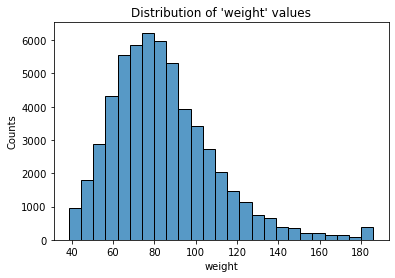

In [37]:
plot_distribution("weight", 25)

### `APACHE II DIAGNOSIS`

*APACHE II* standas for "Acute Physiology and Chronic Health Evaluation II". It is a severity-of-disease classification system, one of several ICU scoring systems. It is applied within 24 hours of admission of a patient to an Intensive Care Unit: an integer score from 0 to 71 is computed based on several measurements. Higher scores correspond to more severe disease and a higher risk of death ([ref](https://en.wikipedia.org/wiki/APACHE_II)).

Values in `apache_2_diagnosis` seem to be around 100, around 200, and around 300. It is not quite clear what kind of diagnosis they indicate, or the methodology these scores were in line.

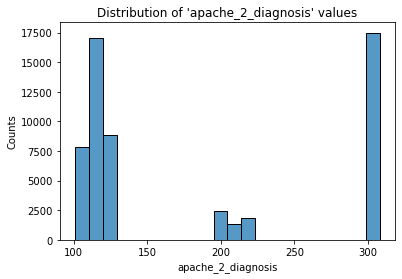

In [38]:
plot_distribution("apache_2_diagnosis", "fd")

### `APACHE III DIAGNOSIS`

A method to compute a refined score. It provides an initial risk classification of severely ill hospitalized patients in defined groups. Adds additional variables to the APACHE III Score including the primary reason for ICU admission. To evaluate the severity of disease 20 physiologic variables are measured, compared to 12 variables for APACHE II. APACHE III scores range from 0 to 299 ([ref](https://en.wikipedia.org/wiki/APACHE_II)).

Patients' APACHE III scores (of range between 0 and 2500) are displayed below.

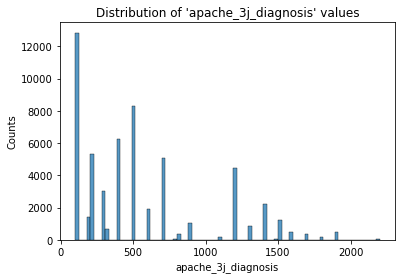

In [39]:
plot_distribution("apache_3j_diagnosis", "fd")

### `APACHE Post Operative`

Values (binary) in this column state if the patient was admitted to ICU after operation (surgery) (True, 1), or not (False, 0).

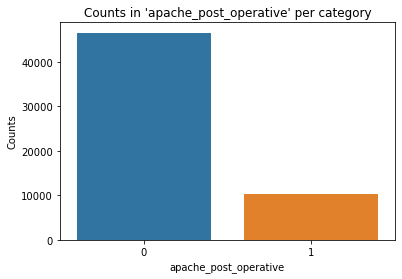

In [40]:
plot_counts("apache_post_operative")

### `Other` categorical features

The subplots below show counts per category in the remaining features with discrete values. I do not go into details as  I did for the previous columns.

In [41]:
cols_to_count = ["arf_apache", "gcs_eyes_apache", "gcs_motor_apache", "gcs_unable_apache",
                "gcs_verbal_apache", "intubated_apache", "ventilated_apache", "aids",
                "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                "leukemia", "lymphoma", "solid_tumor_with_metastasis", "hospital_death"]

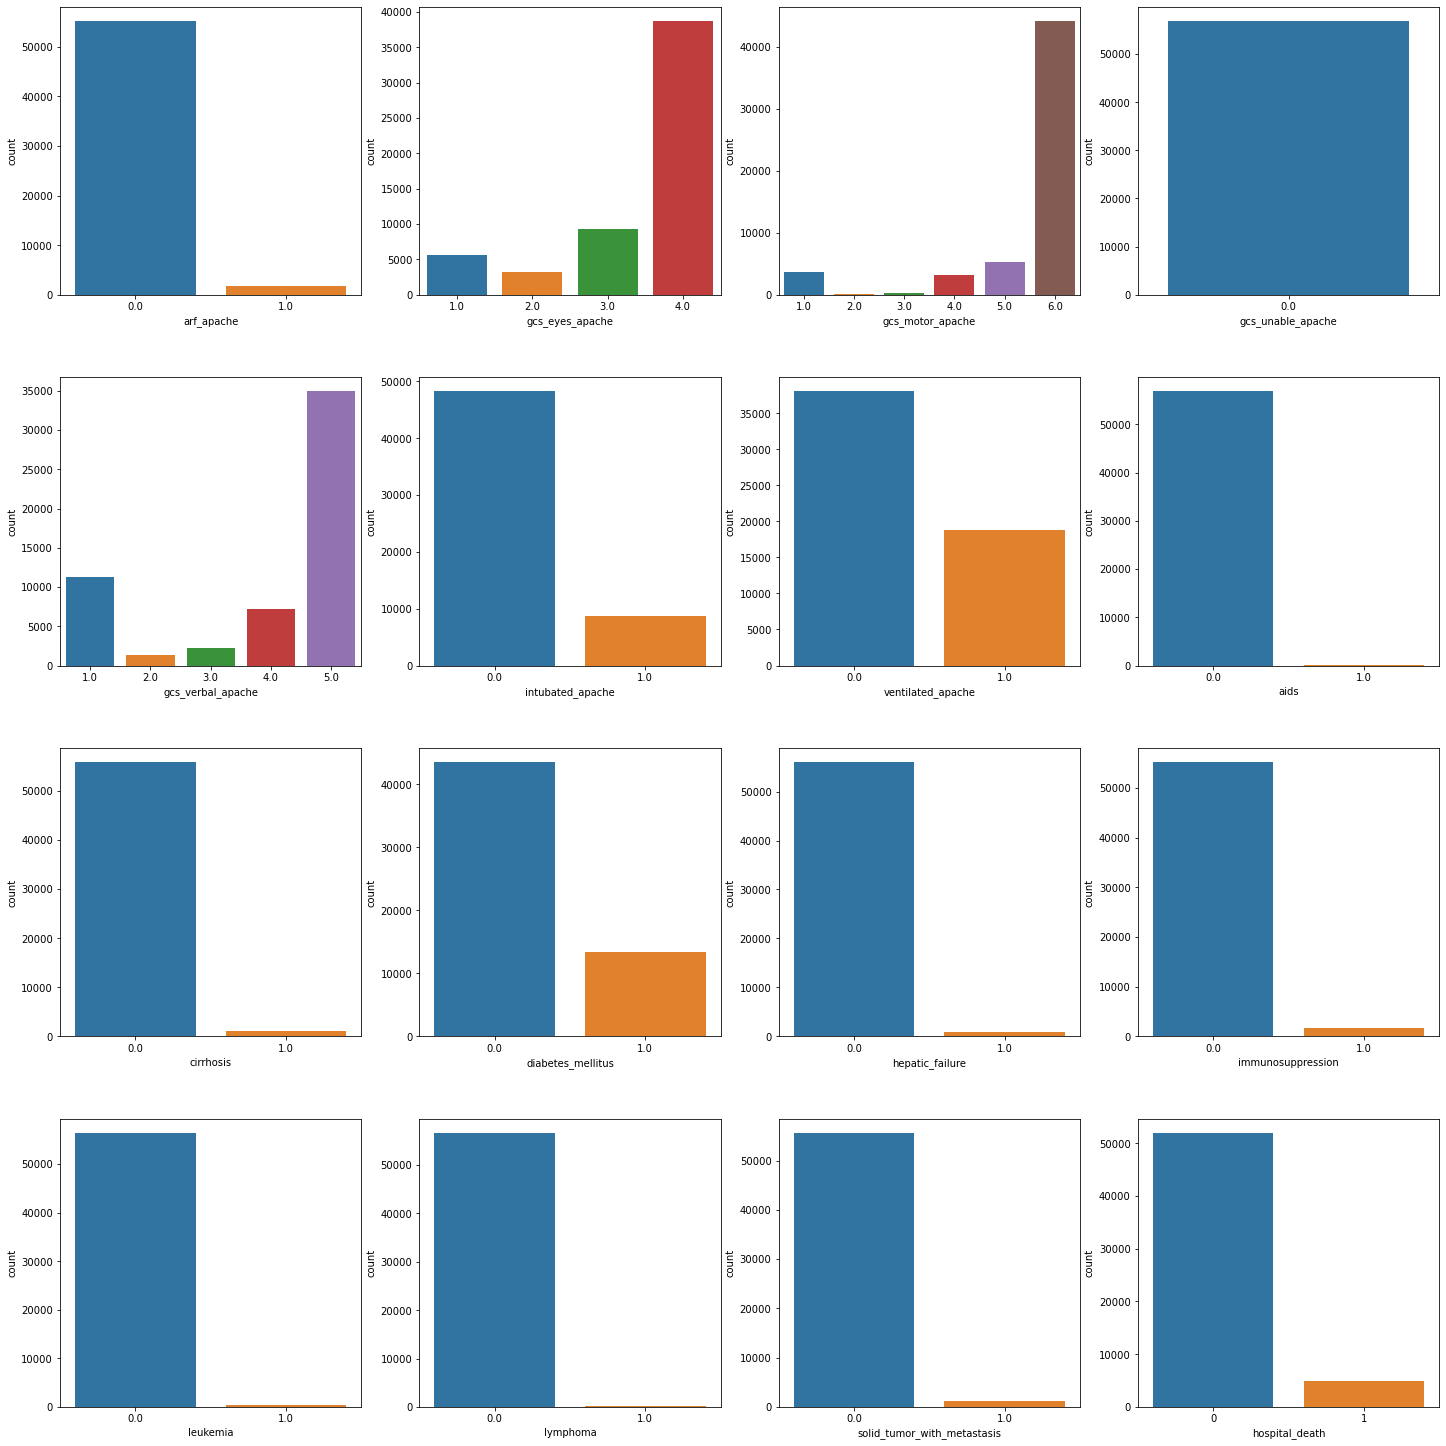

In [42]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20, 20))
index = 0

axs = axs.flatten()
for k, v in patient_dataset[cols_to_count].items():
    sns.countplot(x = v, ax = axs[index])
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

### `Other` numeric features

There are features with normal distribution, with skewed distributions, and with bimodal distribution. The function below helps to plot values of 16 features per hit. Column names are stored in lists. 

In [43]:
def plot_numeric_features(cols):
    """
    Plot distribution of values in numeric features.
    Args:
        cols: list of feature names
    """
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20, 20))
    index = 0

    axs = axs.flatten()
    for k, v in patient_dataset[cols].items():
        sns.histplot(v, ax = axs[index], bins = 40)
        index += 1
    plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

In [44]:
cols_to_hist = ["heart_rate_apache", "map_apache", "resprate_apache", "temp_apache",
               "d1_diasbp_max", "d1_diasbp_min", "d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min", 
                "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min",
               "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", "d1_resprate_min"]

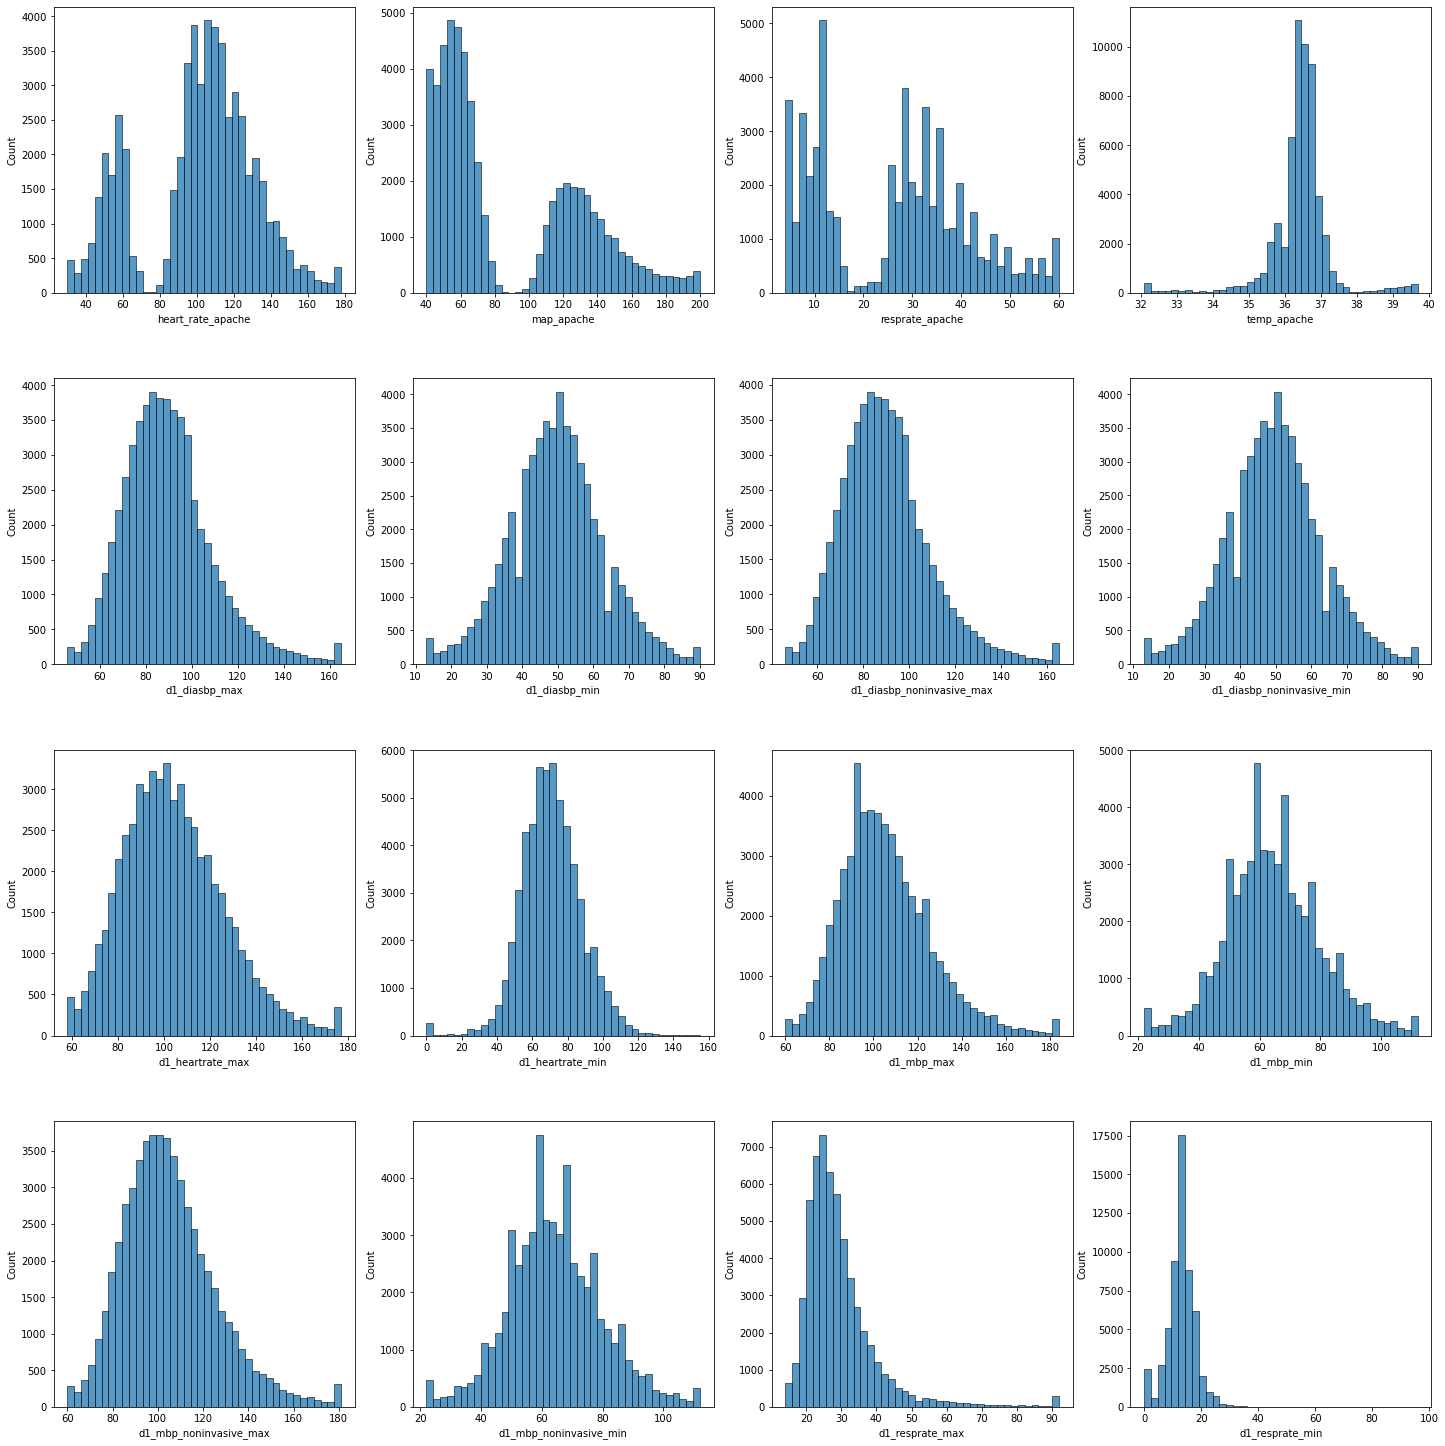

In [45]:
plot_numeric_features(cols_to_hist)

In [46]:
cols_to_hist1 = ["d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min", 
                 "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", "d1_temp_min",
                "h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", "h1_diasbp_noninvasive_min",
                "h1_heartrate_max", "h1_heartrate_min", "h1_mbp_max", "h1_mbp_min"]

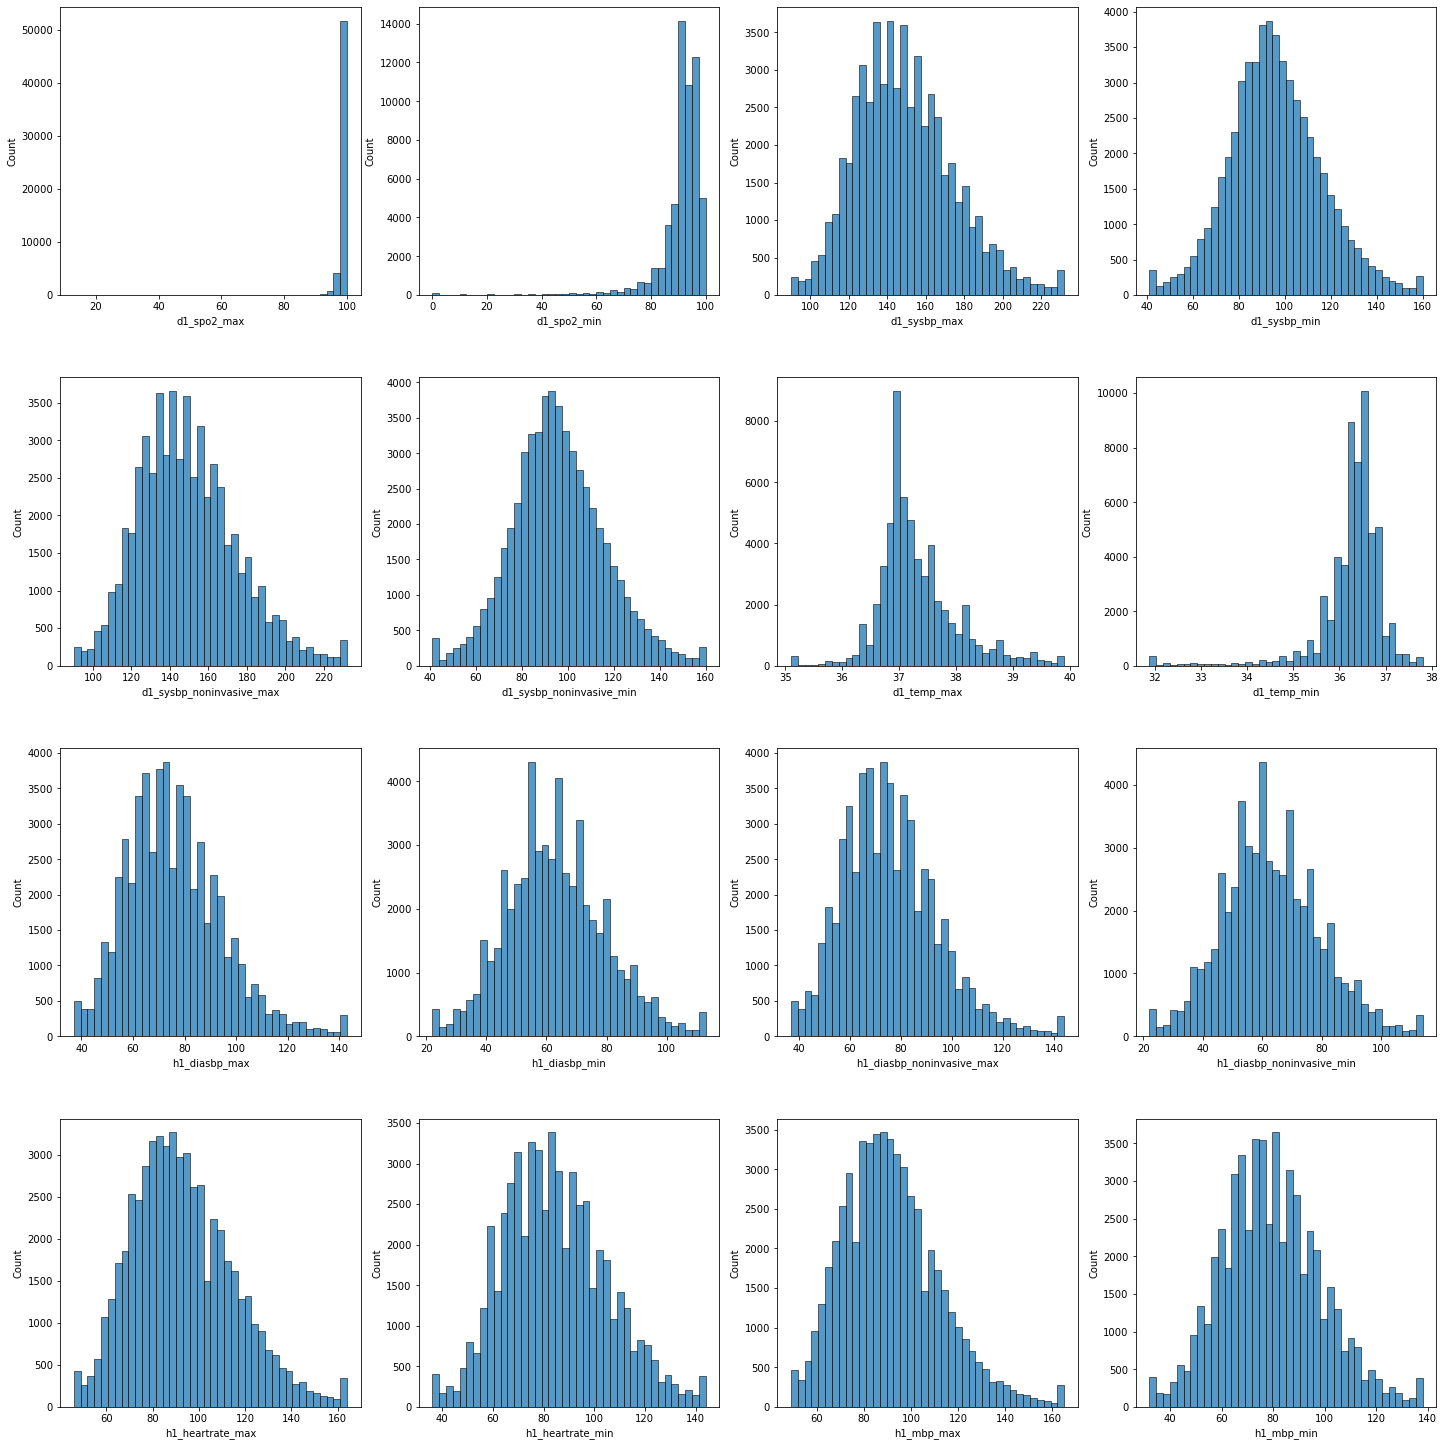

In [47]:
plot_numeric_features(cols_to_hist1)

In [48]:
cols_to_hist2 = ["h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min", "h1_resprate_max", "h1_resprate_min",
                "h1_spo2_max", "h1_spo2_min", "h1_sysbp_max", "h1_sysbp_min",
                "h1_sysbp_noninvasive_max", "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob"]

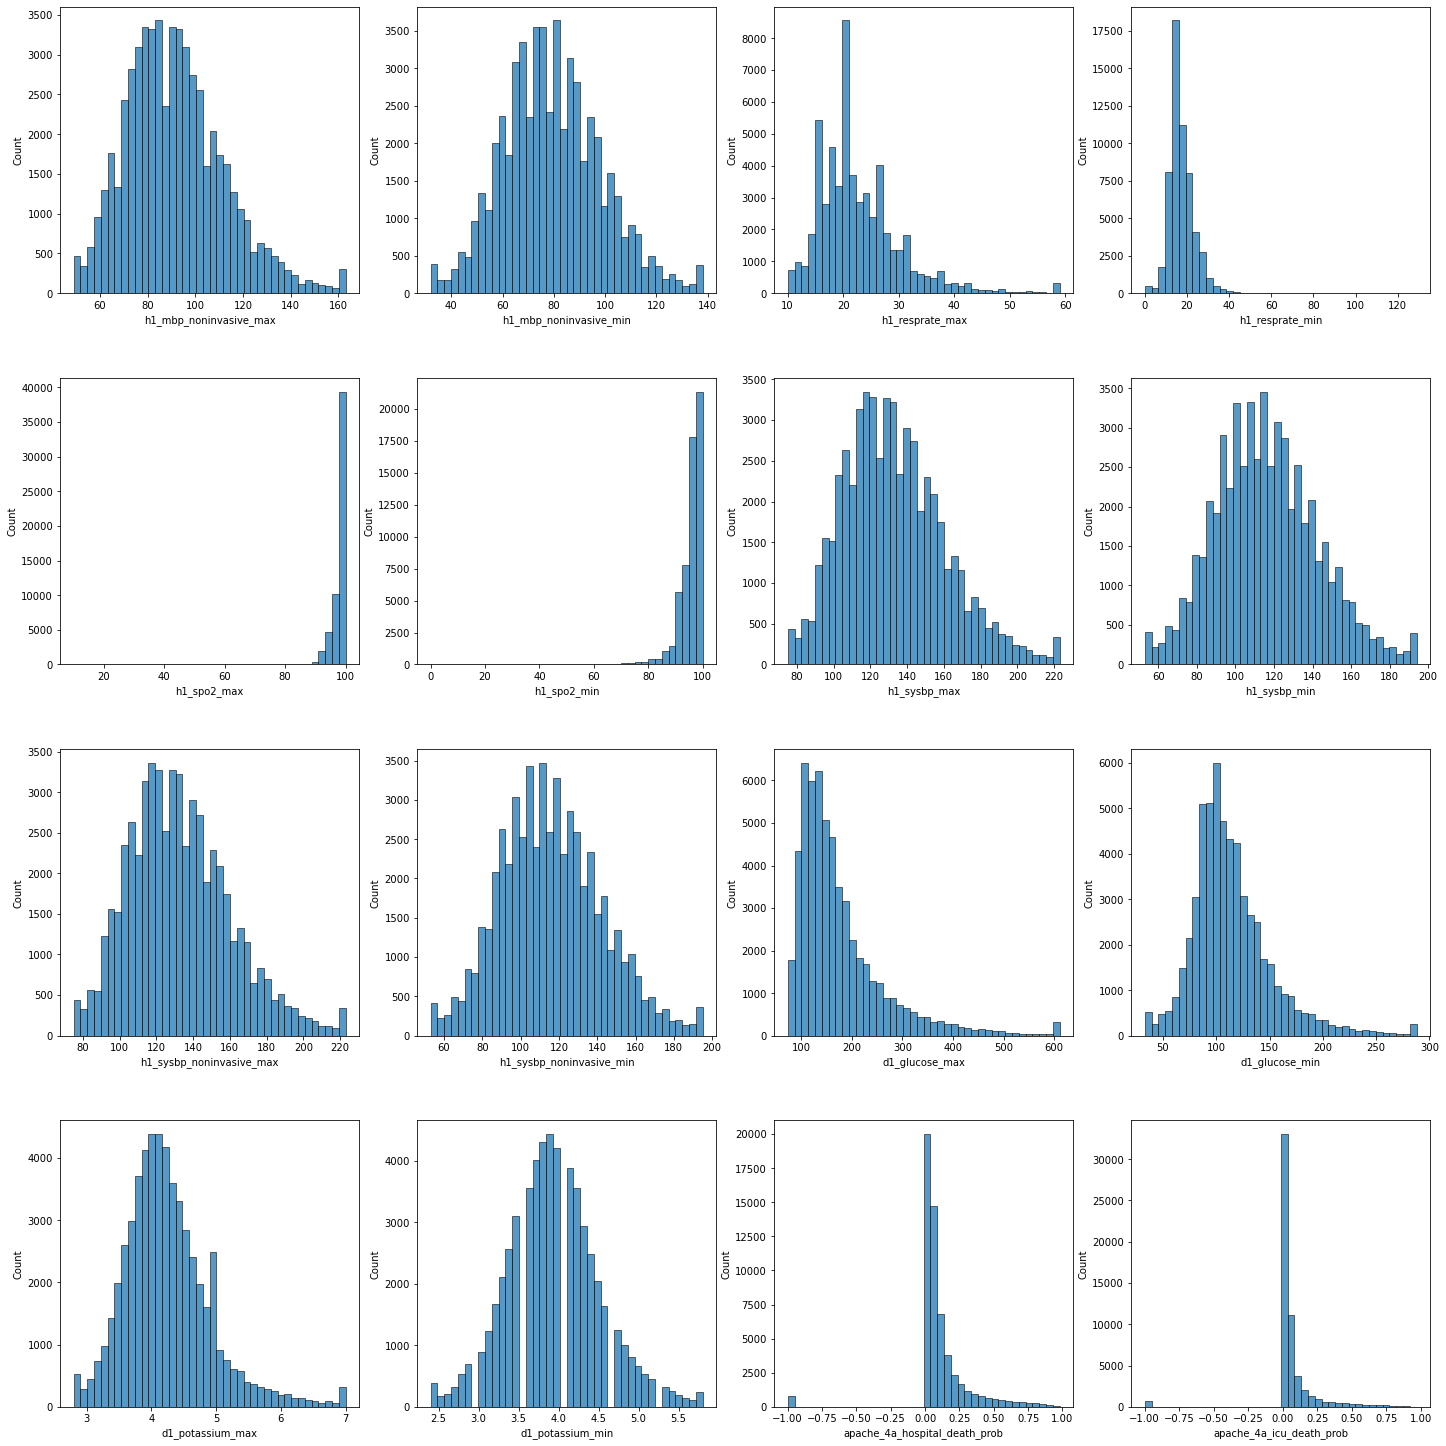

In [49]:
plot_numeric_features(cols_to_hist2)

### `APACHE IIIj Bodysystem`

This column holds categorical values about the body part that needs medical intervention and/or observation, and that was the reason to admit a patient in a hospital (pursuant APACHE III taxonomy). Most patients came with hearth-related issues, followed by those with severe infection (sepsis), respiratory problems, and neurological problems.

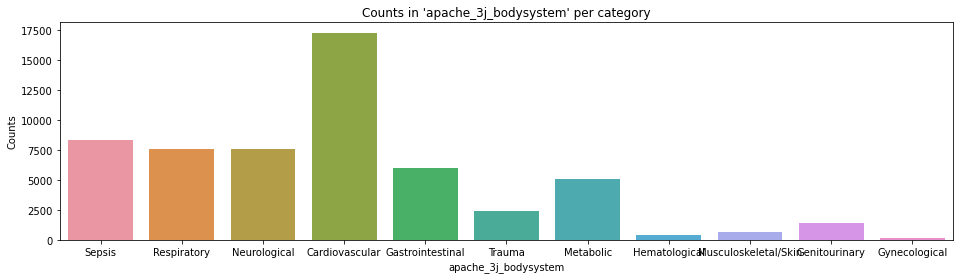

In [50]:
plt.figure(figsize = (16, 4))
plot_counts("apache_3j_bodysystem")

### `APACHE II Bodysystem`

This column holds similar information pursuant APACHE II taxonomy. Preceding data are confirmed: most patients were with cardiovascular issues, followed by those with respiratory or neurological problems.

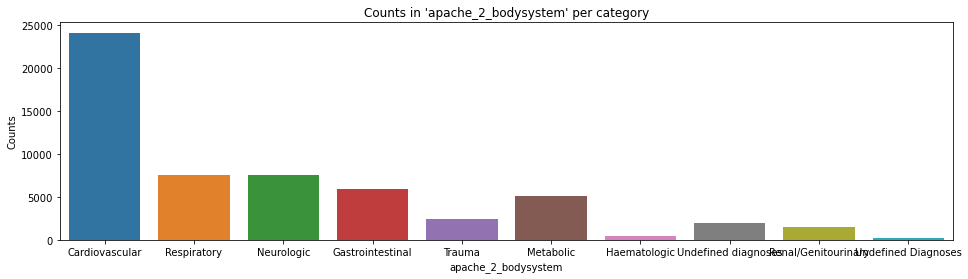

In [51]:
plt.figure(figsize = (16, 4))
plot_counts("apache_2_bodysystem")

### II.3. Explore correlation

Correlation is a statistical term showing any relationship, whether causal or not, between two random variables. Correlation ranges between -1.0 and 1.0. Strong correlation (i.e., equal or close to -1.0 or 1.0) suggest a change in one variable is linked to change in the other variable. Correlation could be positive (greater than 0) - when both variables change in the same direction, and negative (less than 0) - when correlated variables change in the opposite direction.

The Correlation Matrix of Patient Survival Data shows that there is a strong positive correlation between some variables (colored in dark blue) and negative between others (colored in light blue). `gcs_unable_apache` holds only zeros and white blocks do not imply any correlation with other features.

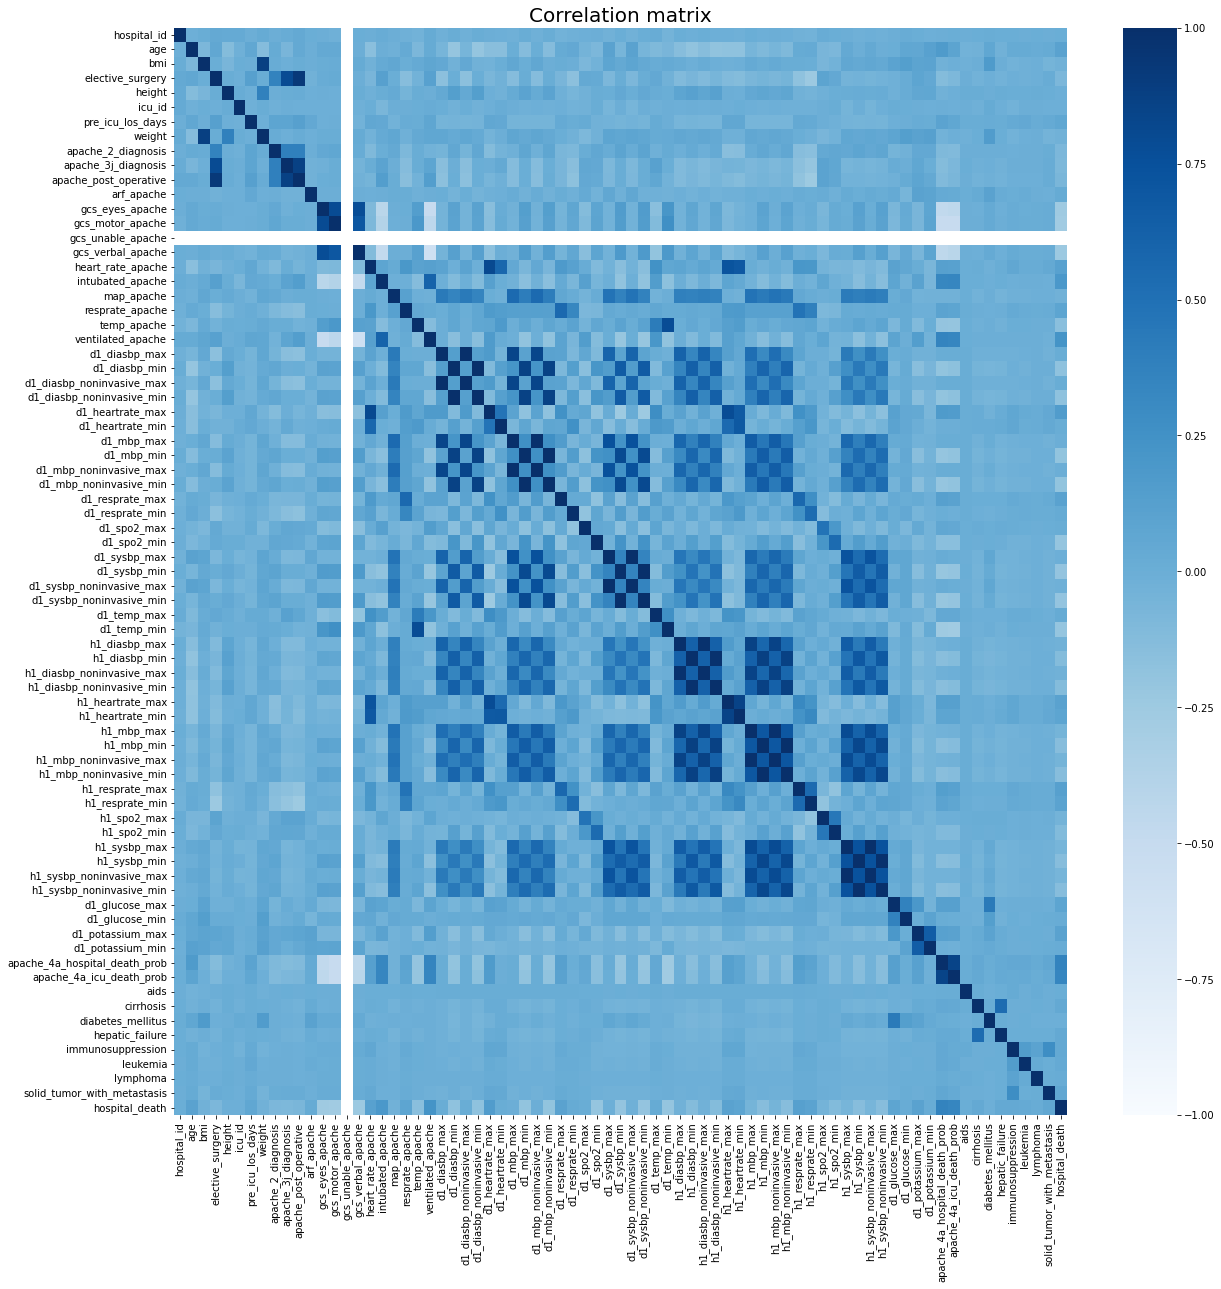

In [52]:
plt.figure(figsize = (20, 20))
sns.heatmap(patient_dataset.corr(), vmin = -1.0, vmax = 1.0, cmap = "Blues")
plt.title("Correlation matrix", fontsize = 20)
plt.show()

## III. Preprocessing

Data need to be preprocessed before being fed through an algorithm. Categorical values are one-hot-encoded, features are separated from labels and normalized, and the dataset is split into train and test parts.

### III.1. One Hot Encoding

Categorical features are one-hot-encoded with Pandas `pd.get_dummies()`. 

In [53]:
categorical_cols = ["ethnicity", "gender", "icu_admit_source", "icu_stay_type", "icu_type",
                    "apache_3j_bodysystem", "apache_2_bodysystem"]

In [54]:
patient_dataset = pd.get_dummies(patient_dataset)

The dataset holds only numerical values now.

In [55]:
patient_dataset.head(3)

hospital_id   age    bmi  elective_surgery  height  icu_id  \
0          118  68.0  22.73                 0   180.3      92   
1           81  77.0  27.42                 0   160.0      90   
2           83  67.0  27.56                 0   190.5      95   

   pre_icu_los_days  weight  apache_2_diagnosis  apache_3j_diagnosis  ...  \
0          0.541667    73.9               113.0               502.01  ...   
1          0.927778    70.2               108.0               203.01  ...   
2          0.000694   100.0               301.0               403.01  ...   

   apache_2_bodysystem_Cardiovascular  apache_2_bodysystem_Gastrointestinal  \
0                                   1                                     0   
1                                   0                                     0   
2                                   0                                     0   

   apache_2_bodysystem_Haematologic  apache_2_bodysystem_Metabolic  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   

   apache_2_bodysystem_Neurologic  apache_2_bodysystem_Renal/Genitourinary  \
0                               0                                        0   
1                               0                                        0   
2                               1                                        0   

   apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
0                                0                           0   
1                                1                           0   
2                                0                           0   

   apache_2_bodysystem_Undefined Diagnoses  \
0                                        0   
1                                        0   
2                                        0   

   apache_2_bodysystem_Undefined diagnoses  
0                                        0  
1                                        0  
2                                        0  

[3 rows x 120 columns]

### III.2. Normalize data

Only features (and not labels) are normalized. The previous operation positioned one-hot-encoded features to the right of labels (`hospital_death`), which is a little bit inconvenient for normalizing data. I use the code line below to reorder columns so as to address this inconvenience.

In [56]:
patient_dataset.columns = ['hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 
                           'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
                           'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 
                           'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 
                           'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
                           'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 
                           'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 
                           'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 
                           'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max',
                           'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 
                           'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 
                           'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 
                           'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min',
                           'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 
                           'h1_sysbp_noninvasive_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 
                           'd1_potassium_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 
                           'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 
                           'lymphoma', 'solid_tumor_with_metastasis', 'ethnicity_African American', 'ethnicity_Asian', 
                           'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 
                           'ethnicity_Other/Unknown', 'gender_F', 'gender_M', 'icu_admit_source_Accident & Emergency',
                           'icu_admit_source_Floor',  'icu_admit_source_Operating Room / Recovery', 
                           'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU', 'icu_stay_type_admit', 
                           'icu_stay_type_readmit', 'icu_stay_type_transfer', 'icu_type_CCU-CTICU', 'icu_type_CSICU', 
                           'icu_type_CTICU', 'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU',
                           'icu_type_Neuro ICU', 'icu_type_SICU', 'apache_3j_bodysystem_Cardiovascular', 
                           'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Genitourinary', 
                           'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological',
                           'apache_3j_bodysystem_Metabolic', 'apache_3j_bodysystem_Musculoskeletal/Skin', 
                           'apache_3j_bodysystem_Neurological', 'apache_3j_bodysystem_Respiratory', 
                           'apache_3j_bodysystem_Sepsis', 'apache_3j_bodysystem_Trauma',
                           'apache_2_bodysystem_Cardiovascular', 'apache_2_bodysystem_Gastrointestinal', 
                           'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_Metabolic', 
                           'apache_2_bodysystem_Neurologic', 'apache_2_bodysystem_Renal/Genitourinary',
                           'apache_2_bodysystem_Respiratory', 'apache_2_bodysystem_Trauma', 
                           'apache_2_bodysystem_Undefined Diagnoses', 'apache_2_bodysystem_Undefined diagnoses', 
                           'hospital_death']

`StandardScaler()` is preferred to `MinMaxScaler()` because it handles outliers better. The scaler is instantiated and stored as an object.

In [57]:
scaler = StandardScaler()
X = scaler.fit_transform(patient_dataset.iloc[:,:-1])

In [58]:
X.dtype

dtype('float64')

Scaled features hold only values. For this reason, they are converted to a Pandas DataFrame and column names attached to them.

In [59]:
X_pd = pd.DataFrame(X)

In [60]:
X_pd.columns = ['hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'weight', 
                'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache',
                'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache',
                'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
                'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
                'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
                'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 
                'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 
                'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 
                'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 
                'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 
                'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 
                'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 
                'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 
                'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 
                'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 
                'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_F', 'gender_M', 
                'icu_admit_source_Accident & Emergency', 'icu_admit_source_Floor', 
                'icu_admit_source_Operating Room / Recovery', 'icu_admit_source_Other Hospital', 
                'icu_admit_source_Other ICU', 'icu_stay_type_admit', 'icu_stay_type_readmit', 'icu_stay_type_transfer',
                'icu_type_CCU-CTICU', 'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU', 'icu_type_MICU', 
                'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU', 'icu_type_SICU', 'apache_3j_bodysystem_Cardiovascular', 
                'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Genitourinary', 
                'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological', 
                'apache_3j_bodysystem_Metabolic', 'apache_3j_bodysystem_Musculoskeletal/Skin', 
                'apache_3j_bodysystem_Neurological', 'apache_3j_bodysystem_Respiratory', 'apache_3j_bodysystem_Sepsis',
                'apache_3j_bodysystem_Trauma', 'apache_2_bodysystem_Cardiovascular', 
                'apache_2_bodysystem_Gastrointestinal', 'apache_2_bodysystem_Haematologic',
                'apache_2_bodysystem_Metabolic', 'apache_2_bodysystem_Neurologic', 
                'apache_2_bodysystem_Renal/Genitourinary', 'apache_2_bodysystem_Respiratory', 
                'apache_2_bodysystem_Trauma', 'apache_2_bodysystem_Undefined Diagnoses',
                'apache_2_bodysystem_Undefined diagnoses']
X_pd.head(3)

hospital_id       age       bmi  elective_surgery    height    icu_id  \
0     0.188767  0.325450 -0.788257         -0.436561  0.976072 -1.954488   
1    -0.383349  0.866479 -0.224575         -0.436561 -0.910210 -1.963504   
2    -0.352424  0.265336 -0.207749         -0.436561  1.923860 -1.940963   

   pre_icu_los_days    weight  apache_2_diagnosis  apache_3j_diagnosis  ...  \
0         -0.117138 -0.419791           -0.805675            -0.100368  ...   
1          0.042106 -0.567062           -0.864054            -0.763903  ...   
2         -0.340251  0.619062            1.389357            -0.320066  ...   

   apache_2_bodysystem_Cardiovascular  apache_2_bodysystem_Gastrointestinal  \
0                           -0.210647                              1.165520   
1                           -0.210647                             -0.857986   
2                           -0.210647                             -0.857986   

   apache_2_bodysystem_Haematologic  apache_2_bodysystem_Metabolic  \
0                         -0.342128                      -0.086928   
1                         -0.342128                      -0.086928   
2                         -0.342128                      -0.086928   

   apache_2_bodysystem_Neurologic  apache_2_bodysystem_Renal/Genitourinary  \
0                       -0.314447                                -0.391089   
1                       -0.314447                                -0.391089   
2                       -0.314447                                 2.556964   

   apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
0                        -0.167234                   -0.392967   
1                        -0.167234                    2.544741   
2                        -0.167234                   -0.392967   

   apache_2_bodysystem_Undefined Diagnoses  \
0                                -0.210647   
1                                -0.210647   
2                                -0.210647   

   apache_2_bodysystem_Undefined diagnoses  
0                                -0.059522  
1                                -0.059522  
2                                -0.059522  

[3 rows x 119 columns]

A brief check shows that features are scaled and stored as a Pandas DataFrame. Labels are placed in `y`.

In [61]:
y = patient_dataset["hospital_death"]

### III.3. Train test split

Features and labels are split into train and test set. Their shapes are checked thereafter. `y` is used to stratify samples so both classes are equally represented in train and test set. The function below displays counts per class in each set and confirms both sets have similar distribution.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_pd, y, train_size = 0.90, shuffle = True, stratify = y)

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51241, 119), (51241,), (5694, 119), (5694,))

In [64]:
def plot_splits():
    """
    Counts and plots labels in each set.   
    """ 
    plt.figure(figsize = (10, 4))
    
    plt.subplot(121)
    plt.title("In train data")
    sns.countplot(data = pd.DataFrame(y_train), x = y_train)

    plt.subplot(122)
    plt.title("In test data")
    sns.countplot(data = pd.DataFrame(y_test), x = y_test)

    plt.tight_layout()
    plt.show()

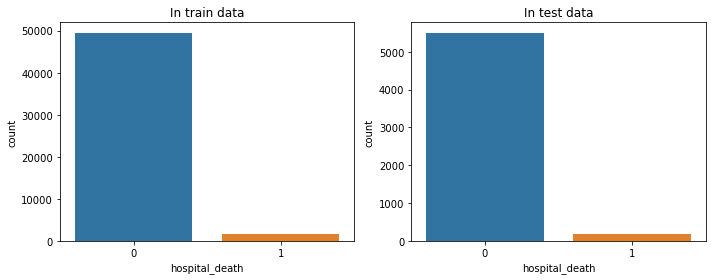

In [65]:
plot_splits()

## IV. Modelling
###  IV.1. Tune Hyperparameters 

The best performing model (the one having a combination of hyperparameters that returns the highest success metric) is chosen after hyperparameter search and tune with [`Optuna`](https://optuna.org/). Data are modelled with cross validation on 5 folds. The code line below defines the number of folds. `RandomForestClassifier()` is used for modelling. The `Optuna` objective function holds its most frequently tuned hyperparameters, and the search space thereof.

In [66]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [67]:
def objective(trial, X, y, cv, scoring):
    """
    An objective function to tune hyperparameters.
    Args:
        trial: an Optuna trial
        X: DataFrame object, features
        y: Series object, Labels
        cv: k folds to cross-validate
        scoring: String, evaluation metric
    Return:
        Mean test accuracy
    """

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100, step = 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step = 1),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "random_state": 42,
        }
    # Perform cross validation
    rf = RandomForestClassifier(**params)

    # Compute scores
    scores = cross_validate(rf, X, y, cv = cv, scoring = scoring, n_jobs = -1)
    accuracy = scores["test_score"].mean()

    return accuracy

The `Optuna` study should maximize the objective function.

In [68]:
study = optuna.create_study(direction = "maximize")

[I 2022-01-24 16:42:59,823] A new study created in memory with name: no-name-54d35b86-1a90-442e-a33a-d5ed335a33b7


Each possible trial combination is stored in `func`, which is optimized during 30 trials.

In [69]:
func = lambda trial: objective(trial, X_train, y_train, cv = kf, scoring = "accuracy")

In [70]:
%%time
study.optimize(func, n_trials = 30)

[I 2022-01-24 16:43:09,736] Trial 0 finished with value: 0.9993364635105773 and parameters: {'n_estimators': 90, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9993364635105773.
[I 2022-01-24 16:43:14,027] Trial 1 finished with value: 0.9659256945461598 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9993364635105773.
[I 2022-01-24 16:43:20,651] Trial 2 finished with value: 0.9998243559718969 and parameters: {'n_estimators': 90, 'max_depth': 6, 'min_samples_leaf': 10, 'max_features': 'auto'}. Best is trial 2 with value: 0.9998243559718969.
[I 2022-01-24 16:43:21,910] Trial 3 finished with value: 0.9988875935345722 and parameters: {'n_estimators': 10, 'max_depth': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9998243559718969.
[I 2022-01-24 16:43:23,638] Trial 4 finished with value: 0.9942233868478173 and parameters: {'n_est

Wall time: 2min 17s


The highest accuracy score reached during hyperparameter optimization is shown below. 

In [71]:
print(f"The highest accuracy reached by this study is: {(study.best_value) * 100}%.")

The highest accuracy reached by this study is: 100.0%.


The best combination of hyperparameters are logged in `best_params` (see below). Their values are stored in variables, which are passed to the modelling algorithm.

In [72]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 50
	max_depth: 10
	min_samples_leaf: 6
	max_features: sqrt


In [73]:
n_estimators = []
max_depth = []
min_samples_leaf = []
max_features = ""

for k, v in study.best_params.items():
    if k == "n_estimators":
        n_estimators.append(v)
        n_estimators = n_estimators[0]
        
    if k == "max_depth":
        max_depth.append(v)
        max_depth = max_depth[0]
        
    if k == "min_samples_leaf":
        min_samples_leaf.append(v)
        min_samples_leaf = min_samples_leaf[0]
        
    if k == "max_features":
        max_features += v
    else:
        pass

Furthermore, these hyperparameters for each run are logged into `Neptune`. 

In [74]:
run["best_params"] = study.best_params

The plot below shows model *accuracy* (objective value) reached on train data during each trial.

In [75]:
plot_optimization_history(study)

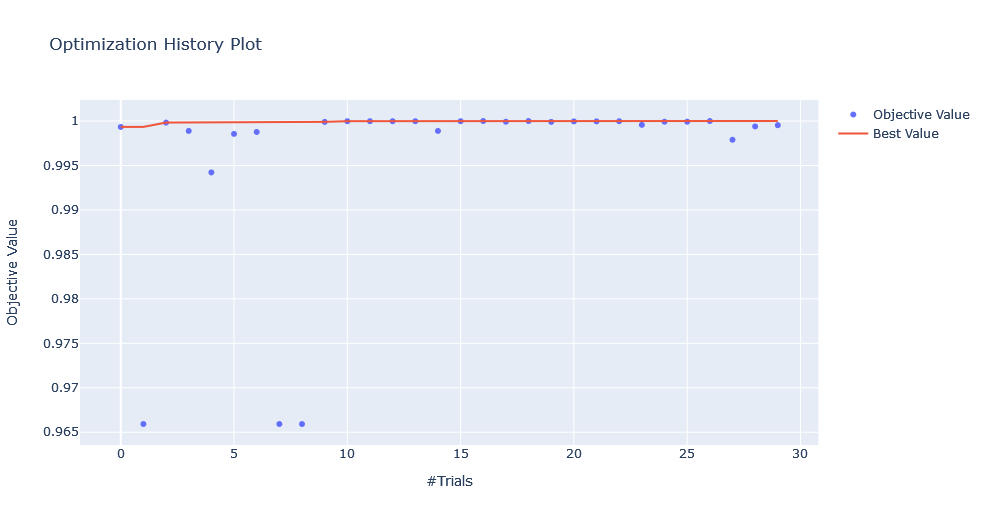

Hyperparameters, in terms of their importance, are displayed in descending order on the plot below.

In [76]:
plot_param_importances(study)

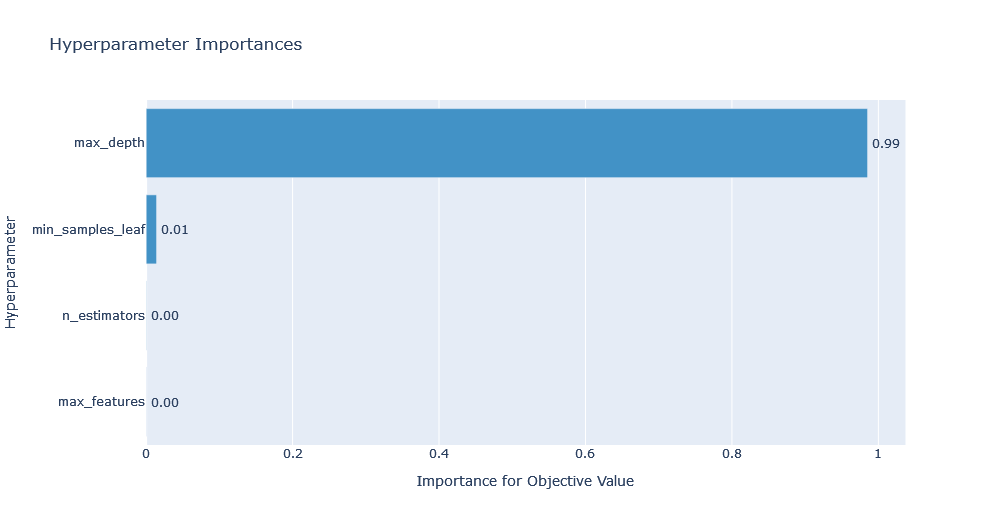

The function below plots parameters relationship on a contour plot. High *accuracy* is colored in light grey. Thus, the deeper the trees in Random Forest, the highest *accuracy* score.

In [77]:
plot_contour(study)

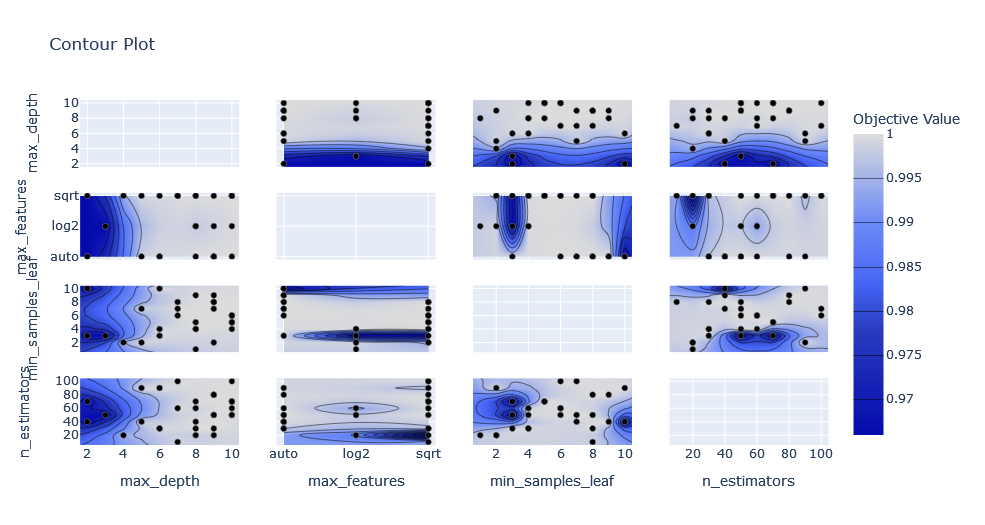

### IV.2. Model data with the best combination of hyperparameters

The best hyperparameters are passed to Random Forest Classifier. It is trained on the training dataset.

In [78]:
rf_class = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, 
                                  min_samples_leaf = min_samples_leaf, max_features = max_features, random_state=42)

In [79]:
rf_class.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                       n_estimators=50, random_state=42)

Model and its coefficients is saved to disk. Thereafter, it is uploaded to `Neptune`.

In [80]:
dump(rf_class, "rf_model.pkl")

['rf_model.pkl']

In [81]:
run["model"].upload('rf_model.pkl')

### IV.3. Evaluate model performance

Model performance is evaluated in terms of its *accuracy* and *f1 score*, which are displayed as figures and on plots.

#### `Accuracy` and `f1 score`

Random Forest reached the highest possible *accuracy* and *f1 score* (1.00) on train data, and 0.99 - on test samples.

In [82]:
y_pred_train = rf_class.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train, average = 'weighted')

In [83]:
print(f"Accuracy on train data: {accuracy_train}")
print(f"F1 score on train data: {f1_train}")

Accuracy on train data: 1.0
F1 score on train data: 1.0


In [84]:
y_pred_test = rf_class.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average = 'weighted')

In [85]:
print(f"Accuracy on test data: {accuracy_test}")
print(f"F1 score on test data: {f1_test}")

Accuracy on test data: 0.9998243765367053
F1 score on test data: 0.9998241576151649


*Accuracy* and *f1 score* are logged into `Neptune` to monitor and track model performance.

In [86]:
run["train/accuracy"] = accuracy_train
run["train/f1"] = f1_train
run["test/accuracy"] = accuracy_test
run["test/f1"] = f1_test

#### `Classification Report`

Classification Report shows how the model performs in terms of *precision*, *recall*, and *f1 score* on each class.  Random Forest properly predicted all test samples but some of class 1.

In [87]:
print(classification_report(y_test, rf_class.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5500
           1       1.00      0.99      1.00       194

    accuracy                           1.00      5694
   macro avg       1.00      1.00      1.00      5694
weighted avg       1.00      1.00      1.00      5694



#### `Confusion Matrix`

*Predicted* class against *Actual* class is shown on Confusion Matrix. All properly predicted samples and the two misclassified are visible below.

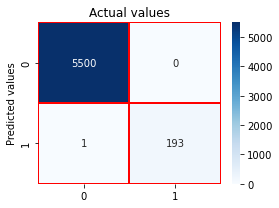

In [88]:
plt.figure(figsize = (4, 3))
sns.heatmap(confusion_matrix(y_test, rf_class.predict(X_test)),
    annot = True, fmt = ".0f", cmap = "Blues", 
    linewidths = 2, linecolor = "red",
    xticklabels = rf_class.classes_,
    yticklabels = rf_class.classes_)
plt.title("Actual values")
plt.ylabel("Predicted values")
plt.tight_layout()
plt.show()

#### `AUC ROC curve`

Area Under the Curve - Receiver Operating Characteristic (AUC - ROC) curve is a performance measurement for classification tasks at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1 ([ref](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)). 

To calculate AUC-ROC, we need to compute the probability a sample could be of any class. The model reached the highest possible ROC score.

In [89]:
y_pred = rf_class.predict_proba(X_test)

In [90]:
print(f"Receiver Operating Characteristic score on test data: {roc_auc_score(y_test, y_pred[:,1], multi_class = 'ovr')}")

Receiver Operating Characteristic score on test data: 1.0


ROC Curves shows that there were not False Positive Samples. Thus, both AUC and ROC for both classes are 1.00.

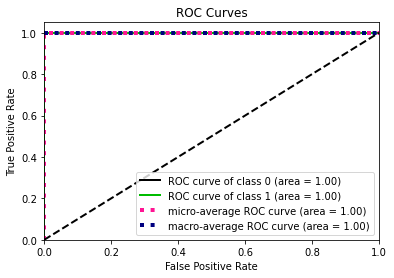

In [91]:
skplt.metrics.plot_roc(y_test, y_pred)
plt.show()

#### `Precision - Recall Curve`

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall) ([ref](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)).

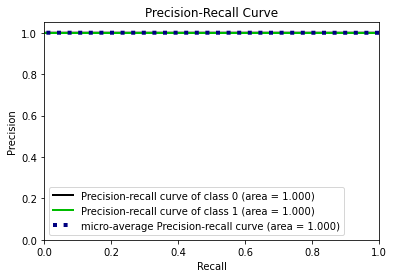

In [92]:
skplt.metrics.plot_precision_recall(y_test, rf_class.predict_proba(X_test), title = 'Precision-Recall Curve')
plt.show()

#### `Feature Importances`

This property shows classifier’s feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance ([ref](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_)).

To show feature importances on a plot, a list of all columns is stored in a variable. It is passed to the plotting function. The most important features are those showing the patient's APACHE II and APACHE III diagnosis.

In [93]:
feat_imp_list = list(X_train.columns)

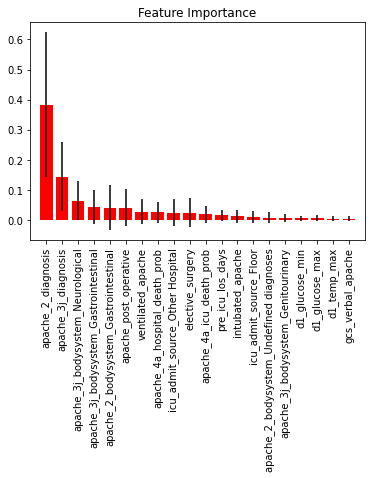

In [94]:
skplt.estimators.plot_feature_importances(rf_class, feature_names = feat_imp_list, x_tick_rotation = 90)
plt.show()

#### `Learning Curve`

The plot below displays train and test learning curves for Random Forest. Cross-validation score improves with getting more training examples.

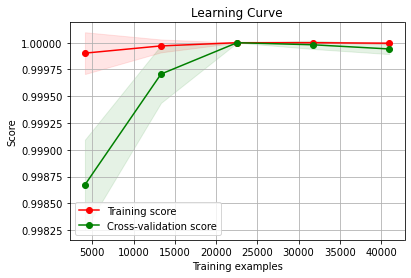

In [95]:
skplt.estimators.plot_learning_curve(rf_class, X_train, y_train)
plt.show()

#### `SHAP values`

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. More about the library and its functions could be found [here](https://shap.readthedocs.io/en/latest/index.html).

SHAP values for all train features seen and modelled by Random Forest are computed below. `summary_plot` shows the impact of a feature on both classes (`hospital_death`) and how they are stacked to create the feature importance plot. This summary plot displays what the Machine Learning algorithm managed to learn from features. It seems all columns have equal impact (were equally important) on both classes.

In [96]:
shap_values = shap.TreeExplainer(rf_class).shap_values(X_train)

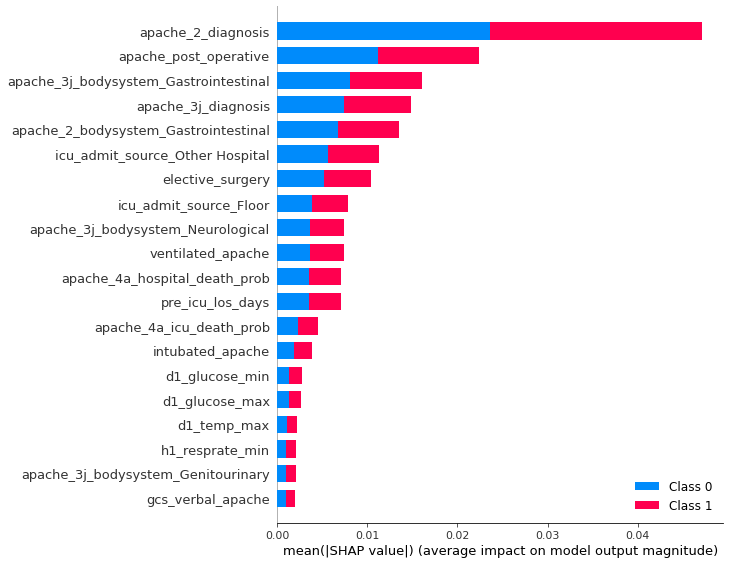

In [97]:
shap.summary_plot(shap_values, X_train)

Very useful SHAP functionality is the *force plot*. It provides explainability of a single model prediction: how features contributed to the model’s prediction for a specific sample, and is very convenient for error analysis or a deep understanding of a particular case.

A sample is taken out of the test data and stored in a variable (`choosen_instance`). 

The first sample holds information about an obese person, aged 74, 165.1 cm tall who weighted 112.2 kg.

In [98]:
X_test.sample(10)

hospital_id       age       bmi  elective_surgery    height    icu_id  \
2221      0.188767  0.686136  1.427074         -0.436561 -0.436316 -1.954488   
23047     0.838197  0.626022  0.091028         -0.436561 -0.445608 -0.250421   
40622    -1.342032  0.385565 -0.298260          2.290629 -0.204016  0.543008   
6802      1.054674 -0.095350  0.501142         -0.436561  0.269878 -1.305319   
41283     1.224763  0.686136 -0.209499         -0.436561  0.028285  0.727840   
11549     0.853660  0.265336  1.056695          2.290629 -0.436316 -0.908605   
3911      0.961898  0.686136 -1.673690         -0.436561 -1.144369 -1.756131   
26814    -1.419345  0.926594 -0.884413         -0.436561 -1.142511 -0.164766   
28861    -1.311106  0.686136  0.574080         -0.436561  0.269878 -0.056572   
30108    -1.233793  0.084993  0.014086         -0.436561 -0.204016  0.110229   

       pre_icu_los_days    weight  apache_2_diagnosis  apache_3j_diagnosis  \
2221          -0.339965  1.104657            1.401032            -0.968067   
23047         -0.278673 -0.105349            1.459411             0.347907   
40622         -0.178716 -0.364068            1.389357             2.127867   
6802          -0.298435  0.610704            1.389357            -0.320066   
41283          1.294574 -0.188935            1.459411             0.347907   
11549         -0.276095  0.770313            0.420273             2.125471   
3911          -0.328508 -1.824831           -0.805675            -0.102498   
26814         -0.253183 -1.195947            0.373571             1.894676   
28861          0.580555  0.682747           -0.805675            -0.100368   
30108         -0.266930 -0.073507           -0.712270            -0.306729   

       ...  apache_2_bodysystem_Cardiovascular  \
2221   ...                           -0.210647   
23047  ...                           -0.210647   
40622  ...                           -0.210647   
6802   ...                           -0.210647   
41283  ...                           -0.210647   
11549  ...                           -0.210647   
3911   ...                           -0.210647   
26814  ...                           -0.210647   
28861  ...                           -0.210647   
30108  ...                           -0.210647   

       apache_2_bodysystem_Gastrointestinal  apache_2_bodysystem_Haematologic  \
2221                               1.165520                         -0.342128   
23047                             -0.857986                         -0.342128   
40622                             -0.857986                         -0.342128   
6802                              -0.857986                         -0.342128   
41283                             -0.857986                         -0.342128   
11549                             -0.857986                         -0.342128   
3911                               1.165520                         -0.342128   
26814                             -0.857986                          2.922883   
28861                              1.165520                         -0.342128   
30108                             -0.857986                         -0.342128   

       apache_2_bodysystem_Metabolic  apache_2_bodysystem_Neurologic  \
2221                       -0.086928                       -0.314447   
23047                      -0.086928                        3.180190   
40622                      -0.086928                       -0.314447   
6802                       -0.086928                       -0.314447   
41283                      -0.086928                        3.180190   
11549                      -0.086928                       -0.314447   
3911                       -0.086928                       -0.314447   
26814                      -0.086928                       -0.314447   
28861                      -0.086928                       -0.314447   
30108                      -0.086928                       -0.314447   

       apache_2_bodysystem_Rena

In [101]:
patient_dataset.loc[[2221]]

hospital_id   age        bmi  elective_surgery  height  icu_id  \
2221          118  74.0  41.162213                 0   165.1      92   

      pre_icu_los_days  weight  apache_2_diagnosis  apache_3j_diagnosis  ...  \
2221          0.001389   112.2               302.0               111.01  ...   

      apache_2_bodysystem_Gastrointestinal  apache_2_bodysystem_Haematologic  \
2221                                     1                                 0   

      apache_2_bodysystem_Metabolic  apache_2_bodysystem_Neurologic  \
2221                              0                               0   

      apache_2_bodysystem_Renal/Genitourinary  \
2221                                        0   

      apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
2221                                0                           0   

      apache_2_bodysystem_Undefined Diagnoses  \
2221                                        0   

      apache_2_bodysystem_Undefined diagnoses  hospital_death  
2221                                        0               0  

[1 rows x 120 columns]

In [102]:
choosen_instance = X_test.loc[[2221]]

In [103]:
explainer = shap.TreeExplainer(rf_class)
shap_values = explainer.shap_values(choosen_instance)

In [104]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

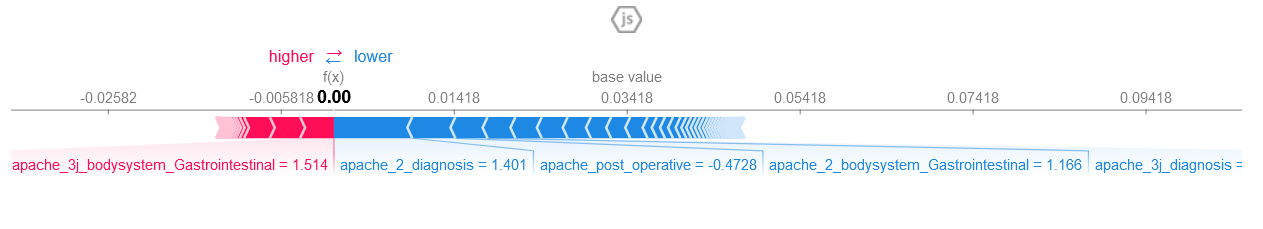

The force plot above shows that:

- The model predicted 0.00 probability of death in hospital.
  
- The base value is the value that would be predicted if there was not information about any features for the current sample. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.03418.

- The numbers on the plot arrows are the value of the feature for this sample: *apache_2_bodysystem_Gastrointestinal* = 1.514 and *apache_2_diagnosis* = 1.401.

- Red represents features that push the model score higher (i.e., towards 1.00), and blue represens features that push the score lower (towards 0.00).

- The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.


Below follows a second example: 73 years old patient, who is obesed and 165.0 tall.

In [105]:
patient_dataset.loc[[23047]]

hospital_id   age        bmi  elective_surgery  height  icu_id  \
23047          160  73.0  30.045914                 0   165.0     470   

       pre_icu_los_days  weight  apache_2_diagnosis  apache_3j_diagnosis  ...  \
23047              0.15    81.8               307.0               704.01  ...   

       apache_2_bodysystem_Gastrointestinal  apache_2_bodysystem_Haematologic  \
23047                                     0                                 0   

       apache_2_bodysystem_Metabolic  apache_2_bodysystem_Neurologic  \
23047                              0                               1   

       apache_2_bodysystem_Renal/Genitourinary  \
23047                                        0   

       apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
23047                                0                           0   

       apache_2_bodysystem_Undefined Diagnoses  \
23047                                        0   

       apache_2_bodysystem_Undefined diagnoses  hospital_death  
23047                                        0               0  

[1 rows x 120 columns]

In [106]:
choosen_instance = X_test.loc[[23047]]
explainer = shap.TreeExplainer(rf_class)
shap_values = explainer.shap_values(choosen_instance)

In [107]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

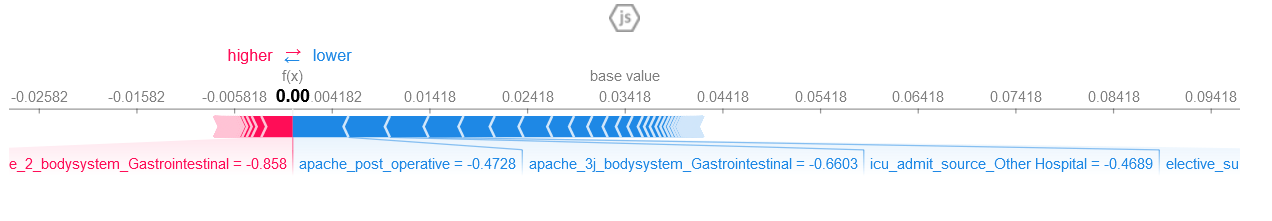

SHAP values for the second example could be interpreted similarly: Blue features push the result towards 0.00, the red ones - in the opposite direction. The probability this patient to die in the hospital is 0.00 (base value 0.03418).

In [108]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


## Conclusion

Medical data are both interesting and important. They not only simplify diagnosis and doctors' work but could save patients' life. As shown above, a person's medical status could be used to predict if he/she is going to survive the stay there.

### `Neptune` artefacts

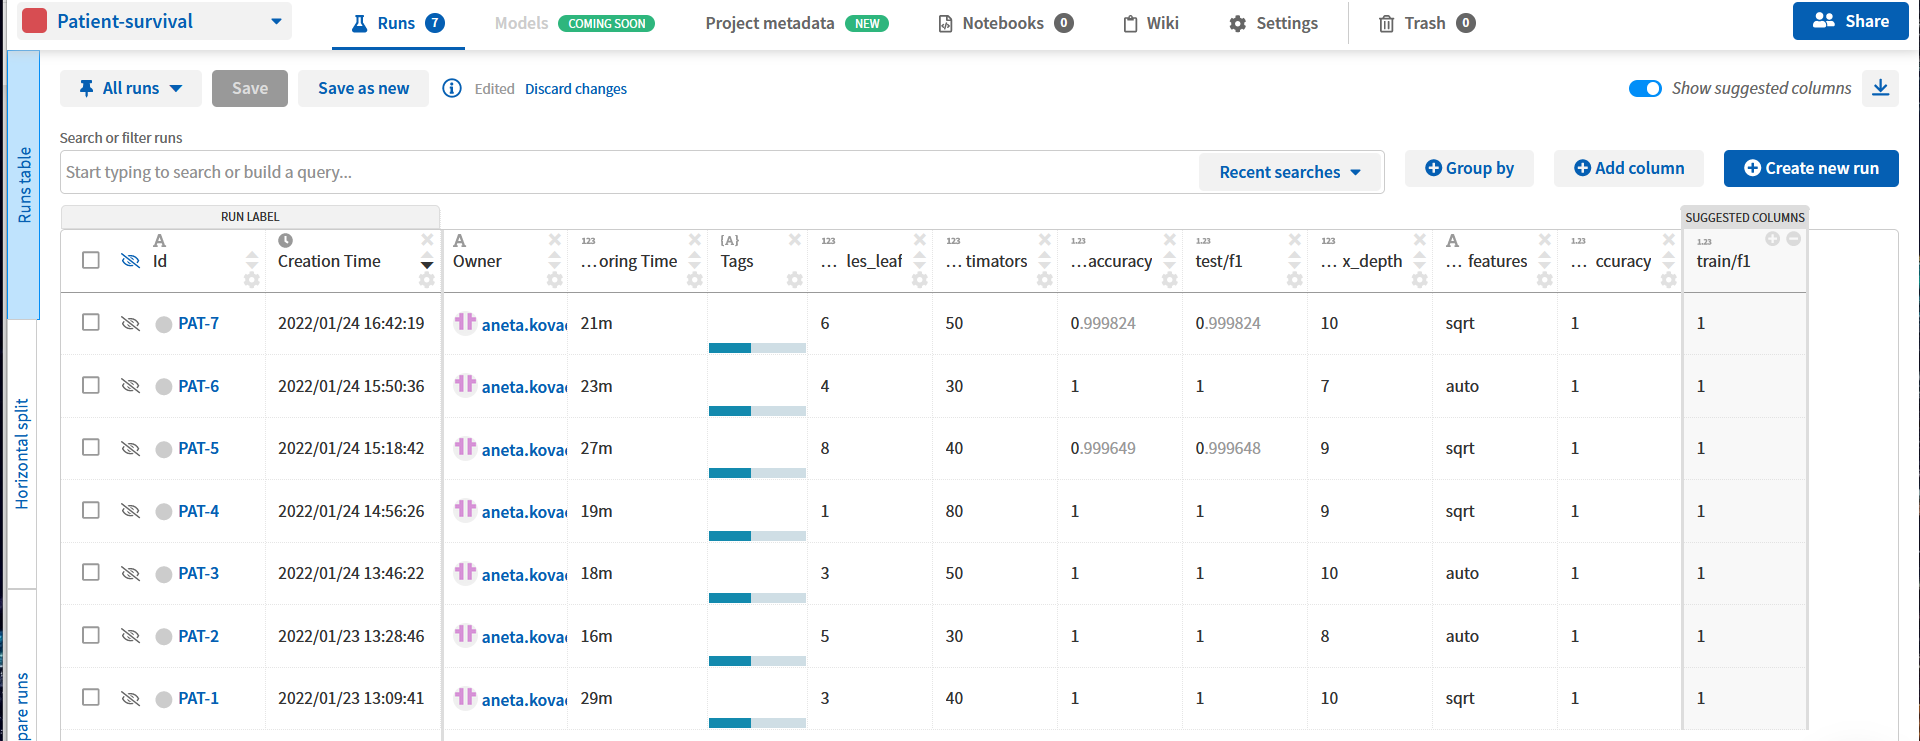